#  Exercices supplémentaires



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABNLP%2005_exo_supp%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=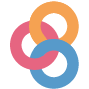)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)

Cette page approfondit certains aspects présentés dans les autres tutoriels. Il s'agit d'une suite d'exercice, avec corrections, pour présenter d'autres aspects du NLP ou pratiquer sur des données différentes

# Exploration des libellés de l'openfood database

L'objectif de cet exercice est d'analyser les termes les plus fréquents
dans les noms de produits de l'openfood database. Au passage, cela permet de réviser les étapes de *preprocessing* (LIEN XXXXX) et d'explorer les enjeux de reconnaissance d'entités nommées. 

Dans cet exercice:

* tokenisation (`nltk`)
* retrait des stop words (`nltk`)
* nuage de mots (`wordcloud`)
* reconnaissance du langage (`fasttext`)
* reconnaissance d'entités nommées (`spacy`)

le tout sur l'OpenFood Database, une base de données alimentaire qui est enrichie de manière collaborative. 

Pour pouvoir utiliser les modèles pré-entraînés de `spaCy`, il faut les télécharger. La méthode préconisée est d'utiliser, depuis un terminal, la commande suivante

In [ ]:
python -m spacy download fr_core_news_sm

Dans un notebook jupyter, il se peut qu'il soit nécessaire de relancer le kernel.

Si l'accès à la ligne de commande n'est pas possible, ou si la commande échoue, il est possible de télécharger le modèle pré-entraîné directement depuis une session `Python`

In [ ]:
import spacy
spacy.cli.download('fr_core_news_sm')

1. Importer le modèle de reconnaissance de langage qui sera utilisé par la suite
ainsi que le corpus Français utilisé par `spacy`



2. Importer les données de l'[openfood database](https://fr.openfoodfacts.org/data) à partir du code suivant

```
## ('/tmp/tmpa2zw4bes.openfood.csv', <http.client.HTTPMessage object at 0x7f4f4b54cb20>)
```

Ces données devraient avoir l'aspect suivant:

```
##      product_name
## 0  jeunes pousses
## 1         L.casei
```

3. Créer une fonction de nettoyage des noms de produits effectuant les 
étapes suivantes:

* tokeniser le texte en question
* retirer la ponctuation et les _stopwords_

Appliquer cette fonction à l'ensemble des noms de produits (variable
`product_name`)


4. Effectuer un nuage de mot sur les libellés avant et après nettoyage
pour comprendre la structure du corpus en question.
Le résultat devrait avoir l'apparence suivante




5. Utiliser la librairie `fasttext` pour extraire les noms de produits
français

* Appliquer le modèle téléchargé précedemment pour déterminer le langage
* Ne récupérer que les libellés français

```
## Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.
```

```
##                    product_name             tokenized language  score_language
## 0                jeunes pousses        jeunes pousses       fr        0.971347
## 7   moutarde au moût de raisin   moutarde moût raisin       fr        0.990018
```

6. Visualiser avec `spacy.displacy` le résultat d'une reconnaissance
d'entités nommées sur 50 données aléatoires. Cela vous semble-t-il satisfaisant ?


<!DOCTYPE html>
<html lang="fr">
    <head>
        <title>displaCy</title>
    </head>

    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">
<figure style="margin-bottom: 6rem">
<div class="entities" style="line-height: 2.5; direction: ltr">Pains au lait </br> Trésor snax chocolat au lait </br> Choucroute d'Alsace garnie </br> Yaourts à la 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Grecque
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 Ananas-Passion </br> Galerie au chocolat </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Huile
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 olive vierge extra </br> Chips steak et 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    oignon 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
Confiture cerise noire </br> 6 oeufs de poules élevées en plein air </br> byphase solution micellaire démaquillante </br> Chip strips goût paprika </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Sauce
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 aigre douce </br> Confiserie au temps des gourmets candy mixte </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Baisers
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 sucrés </br> Olio extra 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    vergine d’
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
oliva </br> Haricots rouge mexicain </br> Le 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Captivant Chocolat noir écorces
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 d'orange confites </br> Purée de framboise sucrée surgelée </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Filet de poulet noir fermier 
 Chausson
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 pommes </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Sauvignon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 blanc </br> miel fleurs variées </br> Yaourt brassé 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Vanillé 
 Jambon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 cru </br> Sorbet plein de fruit mangue </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Museau
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 de porc </br> Baies de Goji séchées </br> Ravioles du Dauphiné </br> Gressins Rustiques au sel marin </br> Croissant X 2 La 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Boulangere 
 Torta
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 crem patissier </br> Comté Marcel Petite bio </br> Mélange Sambahia </br> Miel des 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Ardennes 
 Cerneaux
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 de noix de 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    pecan 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>

<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Moutarde
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 aux herbes de 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    provence
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 et miel </br> Le 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    domaine de Limagne 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
Poudre Moka </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Kruidvat Huile
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 De 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Coco Désodorisée 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
Axoa de veau au piment d'
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Espelette 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
Reblochon de 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    savoie
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 </br> Filets de colin d'alaska </br> Melange de legumes grilles </br> Préparation court bouillon </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Bonbons
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 fraise vanille </br> Velouté asperge </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Brique
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 du forez </br> Ma farine de 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Maïs intégrale 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
Riz au lait a la cassonade </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Barres
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 de céréales</div>
</figure>
</body>
</html>

7. Récupérer dans un vecteur les entités nommées reconnues par `spaCy`.
Regarder les entités reconnues dans les 20 premiers libellés de produits 

```
## [[], [], [('Pistou', 'PER')], [], [], [('Sachet calisson', 'PER')], [], [], [], [], [('Vainilla', 'PER')], [], [('Solène', 'PER')], [], [('Caramel', 'ORG')], [], [('Chouquettes x', 'MISC')], [('maïs bio', 'PER')], [], [('Bouillie', 'MISC')]]
```

<!----
# State of the union address

Un exercice à venir sur l'analyse des discours des présidents américains 
inspiré de https://github.com/BuzzFeedNews/2018-01-trump-state-of-the-union
---->